In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Tutorial 1: Defining a Camera

The first step in creating a sstcam-simulation script is defining the camera. The description of a Camera in the sstcam-simulation package is contained within the `Camera` class. This is simply a container for the different aspects important for the simulation processing. This notebook describes some of the more complex contents of the `Camera` class.

In [2]:
from sstcam_simulation import Camera
Camera?

Init signature:
Camera(
    continuous_readout_duration: int = 1000,
    n_waveform_samples: int = 128,
    trigger_threshold: float = 2,
    coincidence_window: float = 8,
    lookback_time: float = 20,
    mapping: sstcam_simulation.camera.mapping.SSTCameraMapping = <sstcam_simulation.camera.mapping.SSTCameraMapping object at 0x1a22f8f950>,
    reference_pulse: sstcam_simulation.camera.pulse.ReferencePulse = <sstcam_simulation.camera.pulse.GaussianPulse object at 0x1a22f8fc90>,
    photoelectron_spectrum: sstcam_simulation.camera.spe.SPESpectrum = <sstcam_simulation.camera.spe.SiPMGentileSPE object at 0x1a22f8fbd0>,
    electronic_noise: sstcam_simulation.camera.noise.ElectronicNoise = <sstcam_simulation.camera.noise.PerfectElectronics object at 0x1a22e967d0>,
) -> None
Docstring:      Container for properties which define the camera
File:           ~/Software/sstcam-simulation/sstcam_simulation/camera/camera.py
Type:           type
Subclasses:     


## Defaults

All aspects of the `Camera` have a default value, and a reasonable description of the camera can be easily obtained to explore the other aspects of this camera.

In [3]:
camera = Camera()
print(camera)

Camera(continuous_readout_duration=1000, n_waveform_samples=128, trigger_threshold=2, coincidence_window=8, lookback_time=20, mapping=<sstcam_simulation.camera.mapping.SSTCameraMapping object at 0x1a22f8f950>, reference_pulse=<sstcam_simulation.camera.pulse.GaussianPulse object at 0x1a22f8fc90>, photoelectron_spectrum=<sstcam_simulation.camera.spe.SiPMGentileSPE object at 0x1a22f8fbd0>, electronic_noise=<sstcam_simulation.camera.noise.PerfectElectronics object at 0x1a22e967d0>)


# Continuous Readout

As true continuous readout would be very dificult to simulate, an emulation of it is attempted with a readout that is longer than a typical waveform length, and is more finely samples (with sample widths of 0.2 ns).

The readout length (in nanoseconds) is defined with the `continuous_readout_duration` argument.

In [4]:
camera = Camera()
print("default continuous_readout_duration = ", camera.continuous_readout_duration)

default continuous_readout_duration =  1000


In [5]:
camera = Camera(continuous_readout_duration=20000)
print("continuous_readout_duration = ", camera.continuous_readout_duration)

continuous_readout_duration =  20000


The sample width and a time axis for the continuous readout can be accessed through properties of the `Camera`

In [6]:
print(camera.continuous_readout_sample_width)

0.2


In [7]:
print(camera.continuous_readout_time_axis)

[0.00000e+00 2.00000e-01 4.00000e-01 ... 1.99994e+04 1.99996e+04
 1.99998e+04]


## Pixel/Superpixel Mapping

The `SSTCameraMapping` class contains information about the camera mapping and pixel neighbours. It can also be used to create `CameraImage` plots (inherted from CHECLabPy).

In [8]:
from sstcam_simulation.camera import SSTCameraMapping
SSTCameraMapping?

Init signature: SSTCameraMapping(n_pixels=None)
Docstring:      <no docstring>
Init docstring:
Container for the camera coordinates of the SST Camera, and the mapping
between different coordinate sets (e.g. pixel to superpixel)

Parameters
----------
n_pixels : int
    Number of pixels in the simulated camera

Attributes
----------
self.n_pixels : int
    Number of pixels in the simulated camera
self.pixel : CameraCoordinate
    Container for the pixel coordinates
self.pixel_to_superpixel : ndarray
    Superpixel index for each pixel. Shape: (n_pixels)
self.n_superpixels : int
    Number of superpixels in the simulated camera
self.superpixel : CameraCoordinate
    Container for the superpixel coordinates
File:           ~/Software/sstcam-simulation/sstcam_simulation/camera/mapping.py
Type:           type
Subclasses:     


Total number of pixel neighbours =  7910


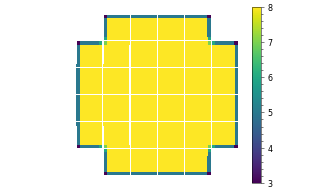

In [9]:
from sstcam_simulation.plotting import CameraImage

camera = Camera()
camera_image = CameraImage.from_coordinates(camera.mapping.pixel)
print("Total number of pixel neighbours = ", len(camera.mapping.pixel.neighbours))
n_neighbours = np.zeros(camera.mapping.n_pixels)
np.add.at(n_neighbours, camera.mapping.pixel.neighbours, 1)
camera_image.image = n_neighbours
camera_image.add_colorbar()

Total number of superpixel neighbours =  1910


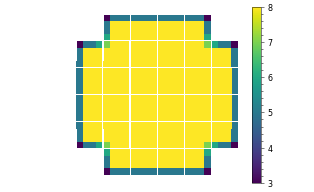

In [10]:
camera = Camera()
camera_image = CameraImage.from_coordinates(camera.mapping.superpixel)
print("Total number of superpixel neighbours = ", len(camera.mapping.superpixel.neighbours))
n_neighbours = np.zeros(camera.mapping.n_superpixels)
np.add.at(n_neighbours, camera.mapping.superpixel.neighbours, 1)
camera_image.image = n_neighbours
camera_image.add_colorbar()

One can specify a camera with as many pixels as it required (e.g. 1 pixel, 4 pixels, 64 pixels...). The number of superpixels is calculated accounting for this configuration.

N_pixels =  1
N_superpixels =  1
Total number of pixel neighbours =  0


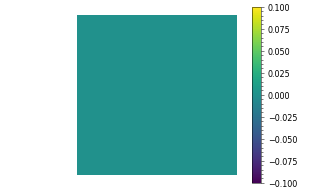

In [11]:
camera = Camera(mapping=SSTCameraMapping(n_pixels=1))
print("N_pixels = ", camera.mapping.n_pixels)
print("N_superpixels = ", camera.mapping.n_superpixels)

camera_image = CameraImage.from_coordinates(camera.mapping.pixel)
print("Total number of pixel neighbours = ", len(camera.mapping.pixel.neighbours))
n_neighbours = np.zeros(camera.mapping.n_pixels)
np.add.at(n_neighbours, camera.mapping.pixel.neighbours, 1)
camera_image.image = n_neighbours
camera_image.add_colorbar()

## Reference Pulse

The `ReferencePulse` is a base for classes which define the reference pulse shape of the camera. When obtaining the camera readout, this pulse shape is convolved with the photoelectrons. The `ReferencePulse` subclass defines the `_function` method, which returns the pulse shape when given the an ndarray containing time values. The `__init__` for a `ReferencePulse` subclass takes in whatever paramters needed to describe the pulse, in addition to the `length` argument, which defines the length for the reference pulse (in nanoseconds). From the definition in `_function` and the configuration arguments to `__init__`, the reference pulse array is generated ready to be used in the convolution.

The reference pulse is normalised to have an integral of 1. Therefore a convolution with this pulse does not change the units of charge.

In [12]:
from sstcam_simulation.camera.pulse import ReferencePulse, GaussianPulse
ReferencePulse?

Init signature: ReferencePulse(duration)
Docstring:      <no docstring>
Init docstring:
Base for classes which define a reference pulse shape

The pulse is evaluated on initialisation.
For a new pulse to be defined, a new class should be initialised.

Parameters
----------
duration : int
    Duration of the reference pulse in nanoseconds
File:           ~/Software/sstcam-simulation/sstcam_simulation/camera/pulse.py
Type:           ABCMeta
Subclasses:     GenericPulse, GaussianPulse


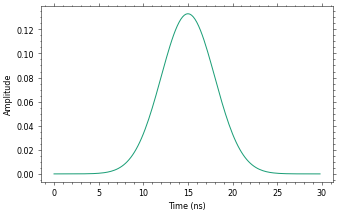

In [13]:
pulse = GaussianPulse(mean=15, sigma=3, duration=30)
camera = Camera(reference_pulse=pulse)
plt.plot(camera.reference_pulse.time, camera.reference_pulse.pulse)
plt.xlabel("Time (ns)")
_ = plt.ylabel("Amplitude")

## SPE Spectrum

The `SPESpectrum` class is the base for classes which define the Probability Density Function for the possible charges a photosensor can report a single photoelectron as. Very similar to the `ReferencePulse` classes, the `_function` methods of the subclass defines the spectrum for different x values. The `__init__` takes arguments which configure the spectrum, and also the `x_min`, `x_max`, and `n_points`, to define the sampling of the spectrum. During the simulation, this spectrum is used with `np.random.choice` to perform [Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to obtain a random value of charge weighted by the spectrum.

The spectrum is normalised to have an integral of 1, and to return an average charge of 1 (such that the units of charge are in photoelectrons).

In [14]:
from sstcam_simulation.camera.spe import SPESpectrum, SiPMGentileSPE
SPESpectrum?

Init signature: SPESpectrum(x_min, x_max, n_points)
Docstring:      <no docstring>
Init docstring:
Base for classes which define the probability density function of the
charge for a single photoelectron.

NOTE: this is **not** the spectrum for an "average illumination" i.e. a Poisson
average close to one. This is the probability density function of the
possible charges a single photoelectron can be measured as. This spectrum
therefore defines the Excess Noise Factor (ENF) of the photosensor. Also,
by definition, it does not include the pedestal peak.

The spectrum is evaluated on initialisation.
For a new spectrum to be defined, a new class should be initialised.

Parameters
----------
x_min : float
    Minimum charge at which the spectrum is defined (Unit: p.e.)
x_max : float
    Maximum charge at which the spectrum is defined (Unit: p.e.)
n_points: int
    Number of points between x_min and x_max used to define the spectrum
File:           ~/Software/sstcam-simulation/sstcam_simulati

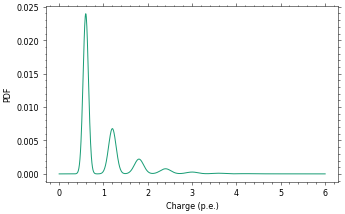

In [15]:
spe_spectrum = SiPMGentileSPE(spe_sigma=0.1, opct=0.4, x_min=0, x_max=10, n_points=1000)
camera = Camera(photoelectron_spectrum=spe_spectrum)
plt.plot(camera.photoelectron_spectrum.x, camera.photoelectron_spectrum.pdf)
plt.xlabel("Charge (p.e.)")
_ = plt.ylabel("PDF")

## Electronic Noise

The `ElectronicNoise` class is the base for classes which define the electronic noise spectrum to be applied to the camera readout. The tranformation to the readout is defined in the `add_to_readout` method in the subclass. This method takes only the `readout` as an argument. The configuration for the electronic noise spectrum is defined in arguments to the `__init__` of the subclass.

In [16]:
from sstcam_simulation.camera.noise import ElectronicNoise, GaussianNoise
ElectronicNoise?

Init signature: ElectronicNoise()
Docstring:     
Base for classes which define an electronic noise spectrum, and how it is
applied to the waveform
File:           ~/Software/sstcam-simulation/sstcam_simulation/camera/noise.py
Type:           ABCMeta
Subclasses:     PerfectElectronics, GaussianNoise


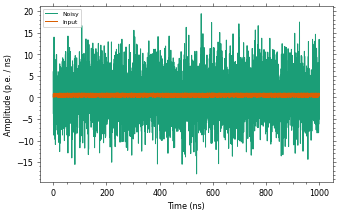

In [17]:
noise = GaussianNoise(stddev=5)
camera = Camera(electronic_noise=noise)
readout = np.random.random((camera.mapping.n_pixels, camera.continuous_readout_time_axis.size))
noisy_readout = camera.electronic_noise.add_to_readout(readout)
plt.plot(camera.continuous_readout_time_axis, noisy_readout[0], label="Noisy")
plt.plot(camera.continuous_readout_time_axis, readout[0], label="Input")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (p.e. / ns)")
_ = plt.legend(loc='best')